<a href="https://colab.research.google.com/github/pablojrios/fluence_maps/blob/master/tf2_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compute predictions on a TF dataset using an stored .h5 model

In [1]:
def isGoogleColab():
    # 'ipykernel.zmqshell' runs in our server
    # 'google.colab._shell' runs in Google Colab
    return get_ipython().__class__.__module__ == 'google.colab._shell'

In [2]:
import numpy as np
import tensorflow as tf
from util.dataset import _tfrecord_dataset_type_from_folder, _parse_jpeg_image_function
from util.preprocess import rescale_0_to_1
import os
import pandas as pd
# Es indistinto usar las métricas de scikit learn o tensorflow
# from sklearn.metrics import mean_absolute_error
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
print('Tensorflow version = {}'.format(tf.__version__))
print('Executing eagerly = {}'.format(tf.executing_eagerly()))

Tensorflow version = 2.2.0
Executing eagerly = True


In [4]:
#%cd /content/drive/My\ Drive/Healthcare/Radioterapia/data/ciolaplata
#!unrar x /content/drive/My\ Drive/Healthcare/Radioterapia/Mapas\ CIO\ La\ Plata/Mapas\ Calculados/2019.rar
#!ls -l 2015/*dcm | wc -l

if isGoogleColab():
    %cd -q '/content'
    if os.path.exists('fluence_maps'):
        !rm -fr fluence_maps

    GIT_USERNAME = "pablojrios"
    GIT_TOKEN = "1d88a0b85d2b00a03796e4d8b7e5f7b249b12f9b"
    !git clone -s https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/fluence_maps.git

    from google.colab import drive
    drive.mount('/content/drive')
    
    !ls -l '/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata/models'
    
    ARG_DATASET_DIR='/content/drive/My Drive/Healthcare/Radioterapia/data/ciolaplata'

In [5]:
#============================DEFINE YOUR ARGUMENTS==============================
if not isGoogleColab():
    # base data directory
    ARG_DATASET_DIR='/hdd/data/radioterapia/ciolaplata'
# folder under ARG_DATASET_DIR path.
ARG_TFDATASET_FOLDER='tfds-2019-localnorm-113355'
ARG_MODEL_NAME = '1611181203' # VGG16 20 de enero 2021
# ARG_MODEL_NAME = '1611181684' # ResNet 18 20 de enero 2021
PART_TRAIN = 'train'
PART_VALIDATION = 'validation'
PART_TEST = 'test'
BATCH_SIZE = 32 # mae puede variar según batch size.
num_workers = 8
ARG_TRANSFORM_GAMMA=False

In [6]:
def getMapDatasetForPartition(part):
    tfdataset_dir = os.path.join(ARG_DATASET_DIR, ARG_TFDATASET_FOLDER)
    raw_test = _tfrecord_dataset_type_from_folder(tfdataset_dir, part)
    print(raw_test)

    # Apply this function to each item in the dataset using the map method:
    IMG_SIZE = 256
    normalization_fn = rescale_0_to_1
    test = raw_test.map(lambda e: _parse_jpeg_image_function(e, IMG_SIZE, normalization_fn, transform_gamma=ARG_TRANSFORM_GAMMA), num_parallel_calls=num_workers)
    
    gamma_values = test.map(lambda image, gamma, filename: gamma)
    gamma_values = np.array(list(gamma_values.as_numpy_iterator()))
    gamma_values[:20]
    
    return test

In [7]:
map_dataset = getMapDatasetForPartition(PART_TRAIN)
print(map_dataset)
print(map_dataset.batch(BATCH_SIZE))

<TFRecordDatasetV2 shapes: (), types: tf.string>
<ParallelMapDataset shapes: ((256, 256, 3), (), ()), types: (tf.float32, tf.float32, tf.string)>
<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>


In [8]:
def getBatchesForPartition(test, part):
    test_batches = test.batch(BATCH_SIZE)
    print(test_batches)

    tmp_test_batches = test_batches.map(lambda image, gamma, filename: (image, gamma))
    
    return tmp_test_batches

In [9]:
# load model
dir = os.path.join(ARG_DATASET_DIR, "models")
saved_model_dir = '{}/{}.h5'.format(dir, ARG_MODEL_NAME)
print(f'Loading model {saved_model_dir}...')
loaded_model = tf.keras.models.load_model(saved_model_dir)

Loading model /hdd/data/radioterapia/ciolaplata/models/1611181203.h5...


In [10]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,977,857
Trainable params: 12,062,209
Non-trainable params: 2,915,648
_________________________________________________________________


In [11]:
tmp_test_batches = getBatchesForPartition(map_dataset, PART_TRAIN)
print(tmp_test_batches)

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.float32)>


In [12]:
def evaluatePartition(tmp_batches, part):
    # Evaluate dataset with the loaded model to calculate loss (mae) because
    # metric value could differ from the one reported during training.
    loss, mse = loaded_model.evaluate(tmp_batches, workers=num_workers, verbose=0)
    print('Loaded model, {} loss: {:5.4f}'.format(part, loss))
    print('Loaded model, {} mse: {:5.4f}\n'.format(part, mse))

In [13]:
evaluatePartition(tmp_test_batches, PART_TRAIN)

Loaded model, train loss: 0.2613
Loaded model, train mse: 0.4580



In [14]:
def getPredictionsDataframe(test, part):
    tmp_batches = getBatchesForPartition(test, part)
    # Make predictions
    predictions = loaded_model.predict(tmp_batches)
    # from (1121,1) to (1121,); ie.: ndim = 2 to ndim = 1
    predictions = predictions.reshape(-1)
    predictions.shape

    tmp_test_dataset = test.map(lambda image, gamma, filename: (filename, gamma))
    print(tmp_test_dataset)

    lst = [(filename.numpy().decode('utf-8'), gamma.numpy()) for filename, gamma in tmp_test_dataset]
    lst2 = [(e[0], e[1], p) for e, p in zip(lst, predictions)]

    # armar un pandas dataframe con el test set completo
    df = pd.DataFrame(lst2, columns=['filename', 'actual gamma', 'predicted gamma'])
    dir = os.path.join(ARG_DATASET_DIR, "predictions")
    predictions_file_path = '{}/predicted_gamma_{}.{}.csv'.format(dir, ARG_MODEL_NAME, part)
    df.to_csv(predictions_file_path, index=False)
    print(f'Predictions saved to {predictions_file_path}.\n')
    
    return df

In [15]:
df = getPredictionsDataframe(map_dataset, PART_TRAIN)

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<MapDataset shapes: ((), ()), types: (tf.string, tf.float32)>
Predictions saved to /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1611181203.train.csv.



In [16]:
def display_scatterplot(part, y, y_hat):
    # mean average error
    mae = mean_absolute_error(y, y_hat)
    print('MAE on %s = %.3f' % (part, mae))

    # correlación entre predichos y observados
    corr = np.corrcoef(y, y_hat)[0,1]
    print('Corr. actual vs predicted = %.3f' % corr)

    r2score = r2_score(y, y_hat)
    print('R^2 = %.3f' % r2score)
    
    # plot calculados vs. predichos (targets)
    fig_dims = (8, 8)
    fig, ax = plt.subplots(figsize=fig_dims)
    plt.title('Actual vs. Predicted (%s)' % part)
    plt.gca().set_aspect('equal')
    sns.scatterplot(y, y_hat, marker='o', ax=ax)
    ax.set(xlabel="Actual", ylabel = "Predicted")
    plt.figure(figsize=(15, 15))
    minimum = int(np.min([y.min(), y_hat.min()]))
    ax.set_xlim([minimum, 100])
    ax.set_ylim([minimum, 100])
    ax.plot([minimum, 100], [minimum, 100], ls="--", c=".7")
    plt.show()

MAE on train = 0.261
Corr. actual vs predicted = 0.978
R^2 = 0.956


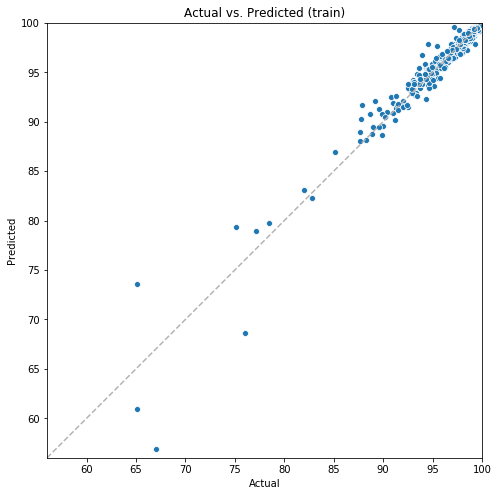

<Figure size 1080x1080 with 0 Axes>

In [17]:
y = df['actual gamma']
y_hat = df['predicted gamma']
display_scatterplot(PART_TRAIN, y, y_hat)

## Train an XGBoost model with extracted CNN features

In [18]:
# For VGG16 only
def extractFeatures(test, part):
    tmp_test_batches = getBatchesForPartition(test, part)
    print(tmp_test_batches)

    inputs=loaded_model.get_layer("vgg16").input
    outputs=loaded_model.get_layer("vgg16").output
    cnn_part=tf.keras.models.Model(inputs, outputs)
    predictions = cnn_part.predict(tmp_test_batches)

    predictions[0][:,:,3].mean()

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(predictions)
    extracted_features = feature_batch_average.numpy()

    from math import isclose
    a=predictions[0][:,:,3].mean()
    b=extracted_features[0][3]
    isclose(a, b, rel_tol=1e-6)

    return extracted_features

In [19]:
extracted_features = extractFeatures(map_dataset, PART_TRAIN)
extracted_features.shape

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.float32)>


(978, 512)

In [20]:
df_features = pd.DataFrame(extracted_features)
df_result = pd.concat([df, df_features], axis=1)

<TFRecordDatasetV2 shapes: (), types: tf.string>
<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
Loaded model, validation loss: 1.2123
Loaded model, validation mse: 7.1444

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<MapDataset shapes: ((), ()), types: (tf.string, tf.float32)>
Predictions saved to /hdd/data/radioterapia/ciolaplata/predictions/predicted_gamma_1611181203.validation.csv.

MAE on validation = 1.212
Corr. actual vs predicted = 0.500
R^2 = 0.223


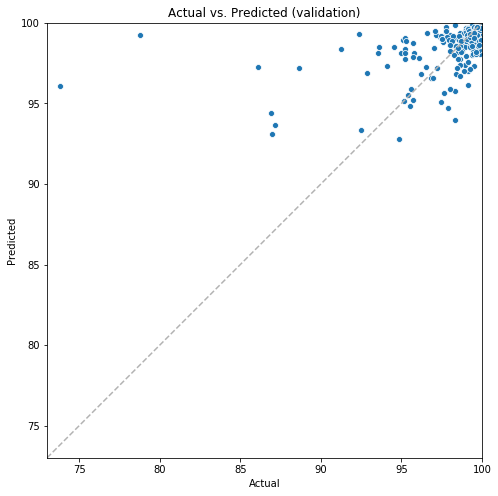

<Figure size 1080x1080 with 0 Axes>

<BatchDataset shapes: ((None, 256, 256, 3), (None,), (None,)), types: (tf.float32, tf.float32, tf.string)>
<MapDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.float32)>


In [21]:
part = PART_VALIDATION
map_dataset = getMapDatasetForPartition(part)
tmp_test_batches = getBatchesForPartition(map_dataset, part)
evaluatePartition(tmp_test_batches, part)
df_validation = getPredictionsDataframe(map_dataset, part)
y = df_validation['actual gamma']
y_hat = df_validation['predicted gamma']
display_scatterplot(PART_VALIDATION, y, y_hat)
extracted_features = extractFeatures(map_dataset, part)
df_features = pd.DataFrame(extracted_features)
df_validation_result = pd.concat([df_validation, df_features], axis=1)

In [22]:
# training
df_result

,filename,actual gamma,predicted gamma,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.776237,99.769829,0.167953,0.00000,0.472464,0.207135,0.194559,0.0,0.000000,...,0.781022,0.266765,0.328887,0.175580,0.082834,0.221993,0.000000,0.045918,0.640745,0.001586
1,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.947762,99.828178,0.166857,0.00000,0.482113,0.206925,0.194286,0.0,0.000000,...,0.776045,0.268796,0.332356,0.175287,0.085085,0.225770,0.000000,0.047755,0.645498,0.000772
2,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.612183,99.707314,0.172737,0.00000,0.473742,0.210703,0.202165,0.0,0.000000,...,0.780489,0.268685,0.319673,0.177759,0.086095,0.225666,0.000000,0.044334,0.641085,0.001590
3,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,98.194702,97.942841,0.171140,0.00000,0.458313,0.209467,0.194372,0.0,0.000048,...,0.777900,0.264080,0.328955,0.176765,0.088671,0.221336,0.009857,0.052366,0.637576,0.001796
4,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.692238,99.691917,0.170809,0.00000,0.473581,0.206685,0.204126,0.0,0.000000,...,0.779048,0.267694,0.319197,0.179508,0.086165,0.226105,0.000000,0.042667,0.642312,0.000899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,98.254997,98.256744,0.166426,0.00000,0.460002,0.203006,0.189938,0.0,0.000000,...,0.777401,0.257767,0.319825,0.164615,0.080748,0.213484,0.000561,0.037137,0.632455,0.001263
974,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,97.714996,98.275444,0.179404,0.00000,0.471701,0.202353,0.186232,0.0,0.000000,...,0.776940,0.262492,0.345467,0.173744,0.083056,0.222648,0.006560,0.049686,0.637785,0.000473
975,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,88.659798,90.745857,0.193731,0.09067,0.444133,0.188686,0.181306,0.0,0.000000,...,0.746853,0.248321,0.308296,0.153712,0.075136,0.205200,0.043957,0.089068,0.615948,0.000819
976,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,98.728401,98.672508,0.162095,0.00000,0.465533,0.194995,0.184998,0.0,0.000000,...,0.771724,0.260101,0.330756,0.162889,0.076203,0.217285,0.000000,0.039516,0.636183,0.002577


In [23]:
# validation
df_validation_result

,filename,actual gamma,predicted gamma,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,94.971298,98.160507,0.188282,0.0,0.472093,0.193211,0.192909,0.0,0.000000,...,0.772296,0.260645,0.343846,0.169443,0.103001,0.216019,0.008451,0.046916,0.640380,0.001671
1,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.654182,99.648567,0.173830,0.0,0.485564,0.205866,0.197323,0.0,0.000000,...,0.777380,0.267690,0.331011,0.180557,0.085298,0.224983,0.000000,0.052339,0.641876,0.000457
2,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,95.114304,98.927109,0.168815,0.0,0.464255,0.213209,0.197604,0.0,0.000546,...,0.780857,0.264557,0.318286,0.176470,0.082935,0.220027,0.008618,0.042858,0.636962,0.001079
3,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.564850,99.463326,0.164420,0.0,0.475968,0.202276,0.194354,0.0,0.000000,...,0.781521,0.265057,0.332248,0.167891,0.080872,0.224488,0.000043,0.043115,0.639536,0.001982
4,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.814941,99.695999,0.170029,0.0,0.477014,0.208818,0.198810,0.0,0.000000,...,0.781630,0.265123,0.323269,0.181745,0.087322,0.225792,0.000047,0.041546,0.640906,0.000919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.662003,99.726044,0.172698,0.0,0.477440,0.209181,0.202041,0.0,0.000000,...,0.782973,0.268207,0.320656,0.178672,0.089873,0.223043,0.000542,0.045129,0.643987,0.001474
240,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,98.691704,98.186646,0.174935,0.0,0.463914,0.199868,0.193313,0.0,0.000000,...,0.776593,0.262688,0.337228,0.170126,0.092717,0.220882,0.000000,0.052043,0.643319,0.000964
241,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,98.516296,98.454277,0.171764,0.0,0.457669,0.203809,0.190322,0.0,0.000000,...,0.771394,0.261082,0.313872,0.167663,0.083667,0.221658,0.000000,0.036833,0.639735,0.001056
242,/hdd/data/radioterapia/ciolaplata/2019/1.3.6.1...,99.819572,98.637718,0.166992,0.0,0.457297,0.203548,0.190077,0.0,0.000627,...,0.778294,0.269827,0.337840,0.177163,0.084986,0.228920,0.006657,0.049885,0.632609,0.001344


In [24]:
if isGoogleColab():
    drive.flush_and_unmount()
    print('All changes made in this colab session should now be visible in Drive.')